# Preparing the datasets as input

### Merge dataframes to have:
- Feature variables: Time (FZ_AB), Richtung (1/2), Day type (Tage_SA/SO/SA_N/SO_N or weekday) and GPS (Latitude/Longitude).
- Target variables: Number of passengers (Besetzung) or Occupancy or number of Freeseats.

Tagtype probably will also be nice to include but eventually not included because the remarks from VBZ is not understandable.

Vehicle type might be also interesting to include (not done yet).


### Data downloaded from:
https://data.stadt-zuerich.ch/dataset/vbz_fahrgastzahlen_ogd
and
https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd

### This code is modified from: 
https://github.com/Chocobosaurus/uzh-data-science-project/blob/main/src/VBZ_Geospatial_Analysis.ipynb
and
https://github.com/VerkehrsbetriebeZuerich/vbz-flow-concept/blob/master/data-treatment-jupyter/vbz-jupyter.ipynb


In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv

In [2]:
#data directory
datadir = ('data/fahrgastzahlen_2023')

full_data = pd.read_csv(os.path.join(datadir, 'REISENDE.csv'), encoding = "utf-8", sep=';')
full_data.head()

,Tagtyp_Id,Linien_Id,Linienname,Plan_Fahrt_Id,Richtung,Sequenz,Haltestellen_Id,Nach_Hst_Id,FZ_AB,Anzahl_Messungen,...,Besetzung,Distanz,Tage_DTV,Tage_DWV,Tage_SA,Tage_SO,Nachtnetz,Tage_SA_N,Tage_SO_N,ID_Abschnitt
0,21,113,15,116279,1,1,161,160.0,09:52:18,9,...,0.44444,289,33.0,0.0,0,33.0,0,0.0,0.0,16100160
1,21,113,15,116279,1,2,160,159.0,09:53:24,9,...,0.88889,535,33.0,0.0,0,33.0,0,0.0,0.0,16000159
2,21,113,15,116279,1,3,159,158.0,09:54:36,9,...,4.77778,282,33.0,0.0,0,33.0,0,0.0,0.0,15900158
3,21,113,15,116279,1,4,158,26.0,09:55:30,9,...,5.88889,424,33.0,0.0,0,33.0,0,0.0,0.0,15800026
4,21,113,15,116279,1,5,26,25.0,09:57:00,9,...,4.22222,258,33.0,0.0,0,33.0,0,0.0,0.0,2600025


In [3]:
# Load the file that contains GPS info and halt_id
haltep = pd.read_csv(os.path.join(datadir, 'haltepunkt.csv'))

# Load the file that contains Halt ID and name: Haltestellen_Id, Haltestellenkurzname
haltest = pd.read_csv(os.path.join(datadir, 'HALTESTELLEN.csv'),encoding = "utf-8", sep=';')

# Load the file that contains Haltestellenkurzname and halt_id
haltest_link = pd.read_csv(os.path.join(datadir, 'haltestelle.csv'),encoding = "utf-8")

# Load the file that contains capacity info = SITZPLAETZE and Plan_Fahrt_Id
capacities = pd.read_csv(os.path.join(datadir, 'GEFAESSGROESSE.csv'), sep=';')

In [4]:
haltepunkte = haltep.copy()
haltestellen_link = haltest_link.copy()
haltestellen = haltest.copy()

# GPS from 'haltepunkte merged to VBZ 'haltestelle' by halt_id, then haltestelle is merged to 'haltestellen' by haltestellenkurzname
# Use only activ stops, keep only halt_id and GPS,
# then group by id and compute the mean of GPS
haltepunkte = haltepunkte[haltepunkte['halt_punkt_ist_aktiv'] == True]
haltepunkte = haltepunkte.drop(columns=['halt_punkt_ist_aktiv','GPS_Bearing','halt_punkt_id','halt_punkt_diva'])
haltepunkte = haltepunkte.groupby(['halt_id']).mean()[['GPS_Latitude','GPS_Longitude']].reset_index()
haltepunkte['halt_id'].duplicated().sum()
# no duplicated items

0

In [5]:
# Keep only halt_id and halt_kurz
haltestellen_link = haltestellen_link.drop(columns=['halt_diva', 'halt_ist_aktiv', 'halt_lang'])
haltestellen = haltestellen.drop(columns=['Haltestellennummer']) # keep Haltestellenlangname for now

halttemp = haltestellen_link.merge(haltepunkte, on='halt_id')

stops = halttemp.merge(haltestellen, left_on='halt_kurz', right_on='Haltestellenkurzname')
stops = stops.drop(columns=['halt_kurz', 'halt_id', 'Haltestellenkurzname', 'Haltestellenlangname'])

In [6]:
stops.head()

,GPS_Latitude,GPS_Longitude,Haltestellen_Id
0,47.452198,8.571273,551
1,47.450139,8.563876,550
2,47.294878,8.564042,674
3,47.370165,8.513761,174
4,47.437911,8.562142,548


In [7]:
capacities.head()

,Plan_Fahrt_Id,SITZPLAETZE,KAP_1m2,KAP_2m2,KAP_3m2,KAP_4m2
0,40287,13,15.5,18.0,21.0,23.0
1,60225,13,15.5,18.0,21.0,23.0
2,60178,13,15.5,18.0,21.0,23.0
3,60218,13,15.5,18.0,21.0,23.0
4,60175,13,15.5,18.0,21.0,23.0


In [8]:
# Merge capacity data
mergedata=full_data.copy()
data = mergedata.merge(capacities, on = 'Plan_Fahrt_Id')

# Calculate Occupancy and Freeseats values
data['Occupancy'] = data['Besetzung'] / data['SITZPLAETZE']
data['Freeseats'] = data['SITZPLAETZE'] - data['Besetzung']

data.head()

,Tagtyp_Id,Linien_Id,Linienname,Plan_Fahrt_Id,Richtung,Sequenz,Haltestellen_Id,Nach_Hst_Id,FZ_AB,Anzahl_Messungen,...,Tage_SA_N,Tage_SO_N,ID_Abschnitt,SITZPLAETZE,KAP_1m2,KAP_2m2,KAP_3m2,KAP_4m2,Occupancy,Freeseats
0,21,113,15,116279,1,1,161,160.0,09:52:18,9,...,0.0,0.0,16100160,66,91.0,116.0,141.0,166.0,0.006734,65.55556
1,21,113,15,116279,1,2,160,159.0,09:53:24,9,...,0.0,0.0,16000159,66,91.0,116.0,141.0,166.0,0.013468,65.11111
2,21,113,15,116279,1,3,159,158.0,09:54:36,9,...,0.0,0.0,15900158,66,91.0,116.0,141.0,166.0,0.072391,61.22222
3,21,113,15,116279,1,4,158,26.0,09:55:30,9,...,0.0,0.0,15800026,66,91.0,116.0,141.0,166.0,0.089226,60.11111
4,21,113,15,116279,1,5,26,25.0,09:57:00,9,...,0.0,0.0,2600025,66,91.0,116.0,141.0,166.0,0.063973,61.77778


In [9]:
# Fix the 4-28 hour expression to 0-23
def replace_hour(hour_str):
    hour = int(hour_str)
    if hour >= 24:
        return str(hour % 24).zfill(2)  # Wrap the hour back to 0-23 and pad with leading zero if necessary
    else:
        return str(hour).zfill(2)

data['FZ_AB'] = data['FZ_AB'].str.replace(r'^(\d{2})', lambda x: replace_hour(x.group(1)), regex=True)

sorted(data.FZ_AB.str.slice(stop=2).unique())

['00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23']

In [10]:
# Convert hours from time_obj to 0.5 hour slots
def time_to_float(time_str):

    time_obj = pd.to_datetime(time_str, format="%H:%M:%S")

    hour = time_obj.hour
    minute = time_obj.minute

    fractional_hours = hour + minute / 60.0
    rounded_hours = round(fractional_hours * 2) / 2  
    return rounded_hours

data['FZ_AB'] = data['FZ_AB'].apply(time_to_float)
data.head()

,Tagtyp_Id,Linien_Id,Linienname,Plan_Fahrt_Id,Richtung,Sequenz,Haltestellen_Id,Nach_Hst_Id,FZ_AB,Anzahl_Messungen,...,Tage_SA_N,Tage_SO_N,ID_Abschnitt,SITZPLAETZE,KAP_1m2,KAP_2m2,KAP_3m2,KAP_4m2,Occupancy,Freeseats
0,21,113,15,116279,1,1,161,160.0,10.0,9,...,0.0,0.0,16100160,66,91.0,116.0,141.0,166.0,0.006734,65.55556
1,21,113,15,116279,1,2,160,159.0,10.0,9,...,0.0,0.0,16000159,66,91.0,116.0,141.0,166.0,0.013468,65.11111
2,21,113,15,116279,1,3,159,158.0,10.0,9,...,0.0,0.0,15900158,66,91.0,116.0,141.0,166.0,0.072391,61.22222
3,21,113,15,116279,1,4,158,26.0,10.0,9,...,0.0,0.0,15800026,66,91.0,116.0,141.0,166.0,0.089226,60.11111
4,21,113,15,116279,1,5,26,25.0,10.0,9,...,0.0,0.0,2600025,66,91.0,116.0,141.0,166.0,0.063973,61.77778


In [11]:
df = data.copy()
sum(df["Haltestellen_Id"].isna())
# No NaN

df = df.drop(columns=['Linien_Id', 'Linienname',
       'Sequenz', 'Nach_Hst_Id',
       'Anzahl_Messungen', 'Einsteiger', 'Aussteiger','Distanz',
       'Tage_DTV', 'Tage_DWV', 'ID_Abschnitt', 'SITZPLAETZE', 'KAP_1m2', 'KAP_2m2',
       'KAP_3m2', 'KAP_4m2']) # Keep Tagtyp_Id for now

# found NaN with terminal stops
df.dropna(inplace=True)

In [12]:
# Merge GPS from stops with df
df = df.merge(stops, on = 'Haltestellen_Id')
df = df.drop(columns=['Plan_Fahrt_Id', 'Haltestellen_Id'])
# Tagtyp makes sense to use, but cannot read the annot table
df = df.drop(columns=['Tagtyp_Id'])
df.head()

,Richtung,FZ_AB,Besetzung,Tage_SA,Tage_SO,Nachtnetz,Tage_SA_N,Tage_SO_N,Occupancy,Freeseats,GPS_Latitude,GPS_Longitude
0,1,10.0,0.44444,0,33.0,0,0.0,0.0,0.006734,65.55556,47.397886,8.541802
1,1,10.0,1.60000,0,33.0,0,0.0,0.0,0.024242,64.40000,47.397886,8.541802
2,1,16.5,32.88235,0,0.0,0,0.0,0.0,0.325568,68.11765,47.397886,8.541802
3,1,16.5,35.39130,0,0.0,0,0.0,0.0,0.368659,60.60870,47.397886,8.541802
4,1,17.0,34.58333,0,0.0,0,0.0,0.0,0.342409,66.41667,47.397886,8.541802


(array([7.00000e+00, 5.20000e+01, 8.24000e+02, 1.02540e+04, 2.38386e+05,
        5.51090e+05, 2.75038e+05, 5.04040e+04, 6.96000e+02, 3.12000e+02]),
 array([-122. ,  -92.3,  -62.6,  -32.9,   -3.2,   26.5,   56.2,   85.9,
         115.6,  145.3,  175. ]),
 <BarContainer object of 10 artists>)

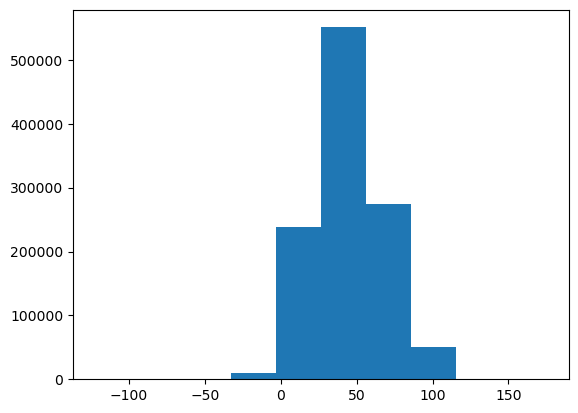

In [13]:
# Check if free seats distribution makes sense
plt.hist(df['Freeseats'])
# The values had some changes before and after merging with stops. Why???

In [14]:
# Change weekday/weekend attribute to binary values
def assign_binary_value(df, column_name):
    binary_values = []
    for index, row in df.iterrows():
        if row[column_name] != 0:
            binary_values.append(1)
        else:
            binary_values.append(0)
    df[column_name] = binary_values  
    return df

df = assign_binary_value(df, 'Tage_SA')
df = assign_binary_value(df, 'Tage_SO')
df = assign_binary_value(df, 'Tage_SA_N')
df = assign_binary_value(df, 'Tage_SO_N')
df.head(20)

,Richtung,FZ_AB,Besetzung,Tage_SA,Tage_SO,Nachtnetz,Tage_SA_N,Tage_SO_N,Occupancy,Freeseats,GPS_Latitude,GPS_Longitude
0,1,10.0,0.44444,0,1,0,0,0,0.006734,65.55556,47.397886,8.541802
1,1,10.0,1.60000,0,1,0,0,0,0.024242,64.40000,47.397886,8.541802
2,1,16.5,32.88235,0,0,0,0,0,0.325568,68.11765,47.397886,8.541802
3,1,16.5,35.39130,0,0,0,0,0,0.368659,60.60870,47.397886,8.541802
4,1,17.0,34.58333,0,0,0,0,0,0.342409,66.41667,47.397886,8.541802
5,1,17.0,32.38095,0,0,0,0,0,0.320603,68.61905,47.397886,8.541802
6,2,18.0,28.20000,0,1,0,0,0,0.339759,54.80000,47.397886,8.541802
7,2,18.0,34.00000,0,1,0,0,0,0.377778,56.00000,47.397886,8.541802
8,2,18.5,37.00000,0,1,0,0,0,0.411111,53.00000,47.397886,8.541802
9,2,11.5,33.53704,0,0,0,0,0,0.372634,56.46296,47.397886,8.541802


In [15]:
#create weekday attribute
def assigndaytype(row):
    if row['Tage_SA'] == 0:
        if row['Tage_SO'] == 0:
            if row['Tage_SA_N'] == 0:
                if row['Tage_SO_N'] == 0:
                    if row['Nachtnetz'] == 0:
                        val=1
                    else:
                        val=0
                else:
                        val=0
            else:
                        val=0
        else:
                        val=0
    else:
                        val=0
    return val
    
df['Weekday'] = df.apply(assigndaytype, axis=1)

In [16]:
df.rename(columns={'FZ_AB': 'Time'}, inplace=True)

In [17]:
# One-hot encoding for categorical values
df.info()
enc_df = pd.get_dummies(df, columns=['Richtung'])
enc_df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1127063 entries, 0 to 1127062
Data columns (total 13 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Richtung       1127063 non-null  int64  
 1   Time           1127063 non-null  float64
 2   Besetzung      1127063 non-null  float64
 3   Tage_SA        1127063 non-null  int64  
 4   Tage_SO        1127063 non-null  int64  
 5   Nachtnetz      1127063 non-null  int64  
 6   Tage_SA_N      1127063 non-null  int64  
 7   Tage_SO_N      1127063 non-null  int64  
 8   Occupancy      1127063 non-null  float64
 9   Freeseats      1127063 non-null  float64
 10  GPS_Latitude   1127063 non-null  float64
 11  GPS_Longitude  1127063 non-null  float64
 12  Weekday        1127063 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 111.8 MB


,Time,Besetzung,Tage_SA,Tage_SO,Nachtnetz,Tage_SA_N,Tage_SO_N,Occupancy,Freeseats,GPS_Latitude,GPS_Longitude,Weekday,Richtung_1,Richtung_2
0,10.0,0.44444,0,1,0,0,0,0.006734,65.55556,47.397886,8.541802,0,True,False
1,10.0,1.60000,0,1,0,0,0,0.024242,64.40000,47.397886,8.541802,0,True,False
2,16.5,32.88235,0,0,0,0,0,0.325568,68.11765,47.397886,8.541802,1,True,False
3,16.5,35.39130,0,0,0,0,0,0.368659,60.60870,47.397886,8.541802,1,True,False
4,17.0,34.58333,0,0,0,0,0,0.342409,66.41667,47.397886,8.541802,1,True,False
5,17.0,32.38095,0,0,0,0,0,0.320603,68.61905,47.397886,8.541802,1,True,False
6,18.0,28.20000,0,1,0,0,0,0.339759,54.80000,47.397886,8.541802,0,False,True
7,18.0,34.00000,0,1,0,0,0,0.377778,56.00000,47.397886,8.541802,0,False,True
8,18.5,37.00000,0,1,0,0,0,0.411111,53.00000,47.397886,8.541802,0,False,True
9,11.5,33.53704,0,0,0,0,0,0.372634,56.46296,47.397886,8.541802,1,False,True


In [18]:
enc_df.to_csv(os.path.join(datadir, 'cleaned.csv'), index=False)